### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('image', cmap='Greys')
import rpy2 
%load_ext rpy2.ipython
%run pybase
%run heavysnow 

### Data 

In [2]:
f=np.array([-1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1])*1.0
n=len(f)
V=list(range(n))
W=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        if abs(i-j)==1: W[i,j]=1
W[0,0]=0
W[n-1,n-1]=0

In [3]:
gs=GraphSignal(V,W,f)

In [4]:
gs.initdist=np.array([1/n]*n)

### HST

In [367]:
%run heavysnow 
hst=HeavySnowTransform(gs)
hst.snow(tau=100000,b=0.01,maxflow=3)

HST (tau= 100000, b=0.01)
100000/100000
HST completed and all history is recorded.


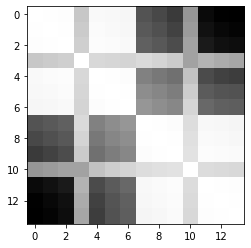

In [412]:
plt.imshow(hst.snowdistance)

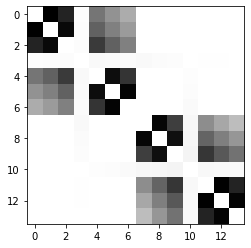

In [568]:
theta=100
hst.snowweight=np.exp(-hst.snowdistance/(theta*hst.tau*hst.b**2))-np.eye(n,n)
plt.imshow(hst.snowweight)

`-` $\theta=10, \theta=100$ 에서의 결과가 우수하다. 

### 시각화를 위해서 R로 자료를 옮김

In [569]:
maxtau=hst.tau
W_Graph=hst.graphweight
W_Euclid=hst.euclidweight
W_HST=hst.snowweight
V=np.array(hst.V)
f=hst.f
n=hst.n
%R -i maxtau,W_Graph,W_Euclid,W_HST,V,f,n

### R을 활용한 시각화 (1): 원래자료 

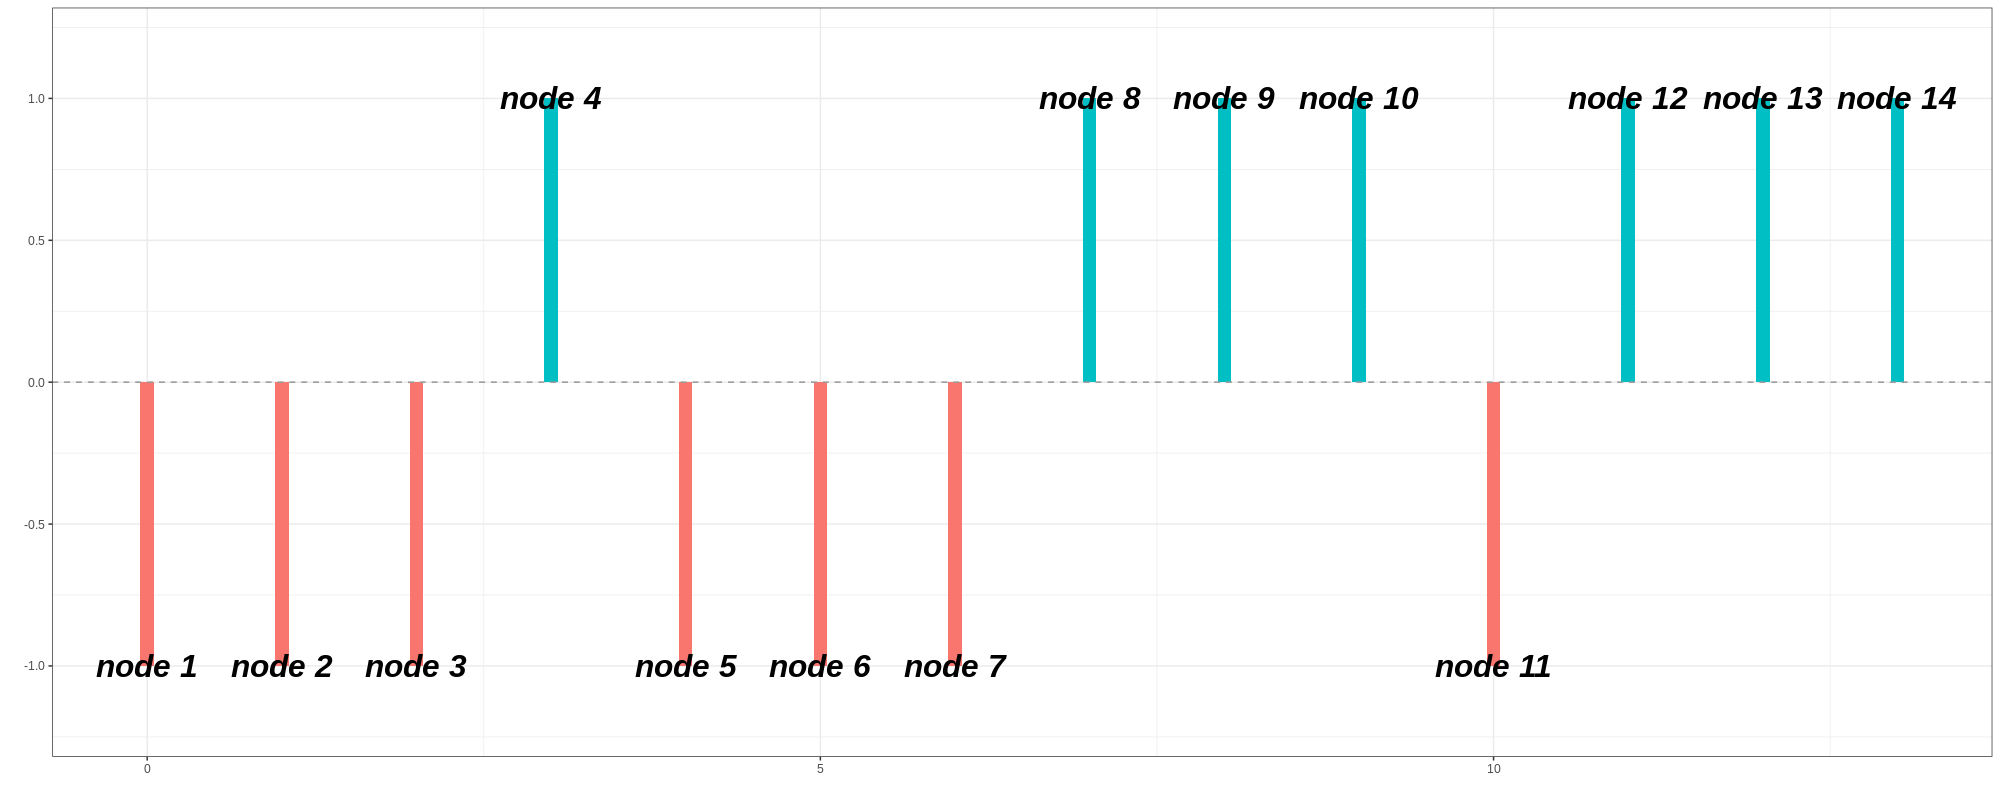

In [570]:
%%R -w 2000 -h 800 -r 100
library(tidyverse)
library(latex2exp)
library(gridExtra)
source('rbase.R')
Vtext=str_c('node ',V+1)
fig0<-ggplot(data=tibble(V=V,f=f,Vtext=Vtext),aes(x=V,y=f,label=Vtext))+
geom_col(aes(fill=(f>0)),width=0.1)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
geom_text(fontface = 4,size=8)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.2,1.2)+
theme(plot.title=element_text(face="bold.italic"))
#ggsave(plot=p0,"./fig/2021-0217_fig0.pdf",width=20,height=6)
fig0

### R을 활용한 시각화 (2): Weight matrix 와 Eigen plot 

`-` `ggplot`에서 `geom_tile`을 사용하기 위해서 매트릭스 형태인 `W_Graph`, `W_Euclid`, `W_HST`를 길게 펼친다. 결과를 각각 `W_Graph_long`, `W_Euclid_long`, `W_HST_long`에 저장한다. 

In [571]:
%%R
grid<-expand.grid(x=1:n,y=1:n)
W_Graph_long<-as_tibble(cbind(grid,as.vector(W_Graph)));names(W_Graph_long)<-c("x","y","W")
W_Euclid_long<-as_tibble(cbind(grid,as.vector(W_Euclid)));names(W_Euclid_long)<-c("x","y","W")
W_HST_long<-as_tibble(cbind(grid,as.vector(W_HST)));names(W_HST_long)<-c("x","y","W")

`-` 그래프퓨리에 변환: $(\bf{f},\bf{W})$에 그래프 퓨리에 변환을 수행함.  

In [572]:
%%R
source('heavysnow.R')
gfftrslt_Euclid<-gfft(f,W_Euclid)
gfftrslt_Graph<-gfft(f,W_Graph)
gfftrslt_HST<-gfft(f,W_HST)

`-` 그래프 퓨리에 변환의 결과 고유치, 고유벡터, $\bf{\bar{f}}$가 반환됨. 

In [573]:
%%R
head(gfftrslt_HST)

$λ
 [1] 1.281581e+00 1.280062e+00 1.277538e+00 1.276594e+00 1.246469e+00
 [6] 1.246289e+00 1.226622e+00 1.223498e+00 1.040855e+00 1.012083e+00
[11] 9.567342e-01 9.183002e-01 1.337453e-02 1.628144e-17

$Ψ
               [,1]         [,2]         [,3]          [,4]        [,5]
 [1,] -1.101322e-02  0.623405435 -0.091622721  0.0017456559  0.24806543
 [2,]  1.205878e-02 -0.755269196  0.101832475 -0.0018036764  0.09749994
 [3,] -2.573593e-03  0.151302392  0.013830158 -0.0006387095 -0.55300723
 [4,] -3.533479e-02  0.001934776 -0.002380270  0.0010829689 -0.01418293
 [5,]  5.657077e-03  0.020641957  0.146149059 -0.0047285571  0.42944573
 [6,] -4.457739e-05 -0.100557489 -0.758698999  0.0208523679 -0.06840576
 [7,] -1.383726e-05  0.084966266  0.618622425 -0.0161356769 -0.14706653
 [8,]  6.379135e-01  0.009833070 -0.003446524 -0.0341177590  0.07952772
 [9,] -7.573498e-01 -0.012587447  0.004061202  0.0444005100  0.04376935
[10,]  1.154586e-01  0.003127545  0.005845689 -0.0075676043 -0.30295320
[11,

`-` 시각화코드 

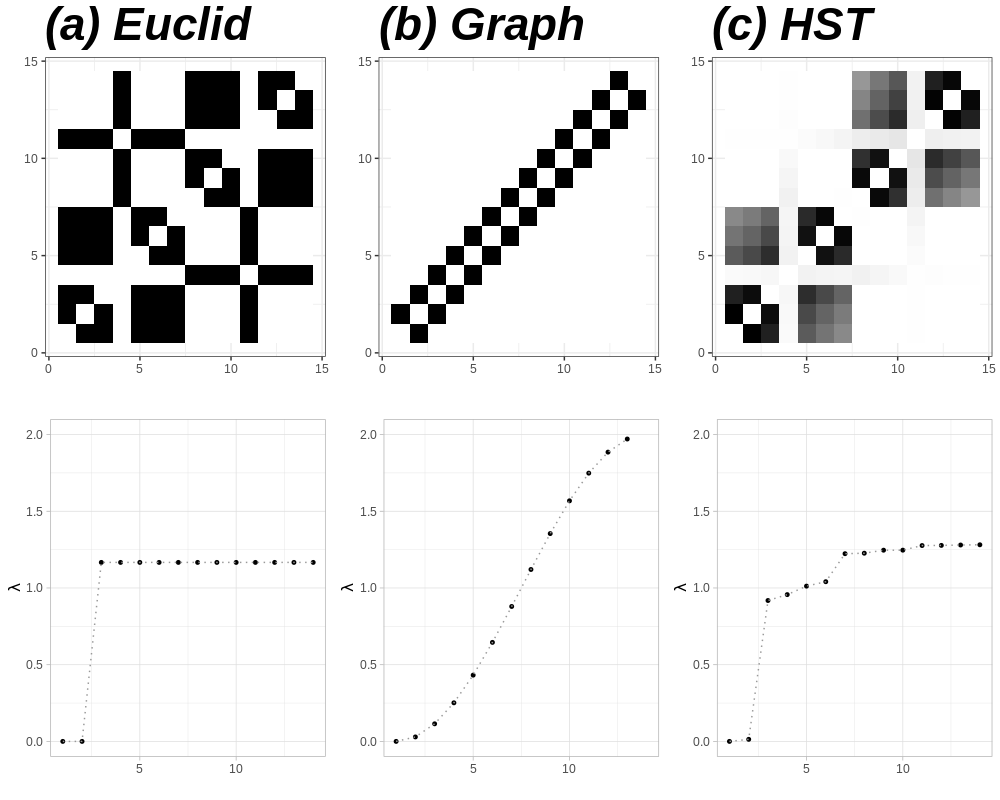

In [574]:
%%R -w 1000 -h 800 -r 100
library(gridExtra)

fig1_1<-ggplot()+geom_tile(data=W_Euclid_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="white",high="black")+
labs(fill=TeX('$W$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(a) Euclid")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_2<-ggplot()+geom_tile(data=W_Graph_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="white",high="black")+
labs(fill=TeX('$\\hat{W}$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(b) Graph")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_3<-ggplot()+geom_tile(data=W_HST_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="white",high="black")+
labs(fill=TeX('$\\hat{W}(\\tau)$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(c) HST")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_4<-eigenplot(gfftrslt_Euclid)+ylim(0,2)+theme_light()
fig1_5<-eigenplot(gfftrslt_Graph)+ylim(0,2)+theme_light()
fig1_6<-eigenplot(gfftrslt_HST)+ylim(0,2)+theme_light()
fig1=grid.arrange(fig1_1,fig1_2,fig1_3,fig1_4,fig1_5,fig1_6,ncol=3,nrow=2)
fig1
ggsave(plot=fig1,"2021-08-14-EX1(0).pdf",width=15,height=10)

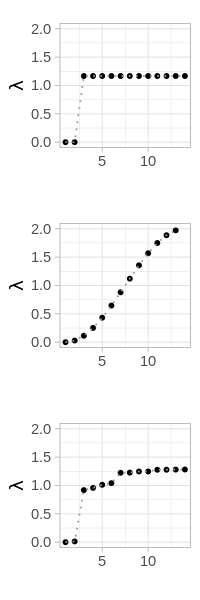

In [575]:
%%R -w 200 -h 600 -r 120
fig_= grid.arrange(fig1_4,fig1_5,fig1_6,nrow=3)
ggsave(plot=fig_,"2021-08-14-EX1(1).pdf",width=2,height=6)

### R을 활용한 시각화 (3): Decomposition 

`-` 디콤포지션을 수행하고 결과를 저장: $(\bf{f},\bf{W})$에 decomposition을 수행하고 그 결과를 각각 `decomprslt_Euclid`, `decomprslt_Graph`, `decomprslt_HST`에 저장한다. 

In [576]:
%%R 
decomprslt_Euclid<-decompose(f,W_Euclid,V=1:n) # 0, 35000, 60000, 80000
decomprslt_Graph<-decompose(f,W_Graph,V=1:n) # 0, 35000, 60000, 80000
decomprslt_HST<-decompose(f,W_HST,V=1:n) # 0, 35000, 60000, 80000

`-` 디콤포지션 결과는 아래와 같은 형태임 

In [577]:
%%R
head(decomprslt_Euclid)

# A tibble: 6 × 5
      V Vindex eigenvectorindex      fhat eigenvalue
  <int>  <int>            <dbl>     <dbl>      <dbl>
1     1      1                1  1.45e-32   3.28e-18
2     2      2                1  2.48e-17   3.28e-18
3     3      3                1 -2.02e-16   3.28e-18
4     4      4                1  1   e+ 0   3.28e-18
5     5      5                1  8.73e-17   3.28e-18
6     6      6                1 -6.32e-17   3.28e-18


In [578]:
%%R 
decomprslt_Euclid$method="Euclid"
decomprslt_Graph$method="Graph"
decomprslt_HST$method="HST"
decomprslt<-rbind(decomprslt_Euclid,decomprslt_Graph,decomprslt_HST)

`-` 디콤포지션결과를 시각화한다. `geom_col`과 `facet_grid`를 이용. 

In [579]:
%%R -w 2000 -h 500 -r 100
fig2<-ggplot(data=decomprslt,aes(x=V,y=fhat))+
geom_col(aes(fill=fhat>0),width=0.7)+facet_grid(method~eigenvectorindex)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.2,1.2)+
theme(plot.title=element_text(face="bold.italic"))
fig2
ggsave(plot=fig2,"2021-08-14-EX1(2).pdf",width=20,height=6)

### Appendix 

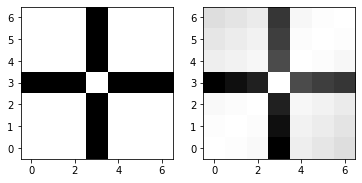

In [580]:
_, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(hst.eucliddistance[:7,:7],origin='lower')
ax2.imshow(hst.snowdistance[:7,:7],origin='lower')
plt.show()

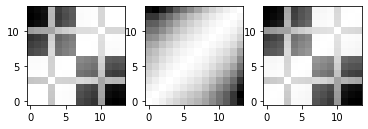

In [587]:
brk=10000
p, (ax1,ax2,ax3) = plt.subplots(1,3) 
ax1.imshow(l2distance(hst.snowygrounds[:,0:brk]),origin='lower')
ax2.imshow(l2distance(hst.snowygrounds[:,brk:]),origin='lower')
ax3.imshow(hst.snowdistance,origin='lower')
#ax4.imshow(diffusion_distance)
#plt.show()
p.savefig('temp.pdf',transparent=True)

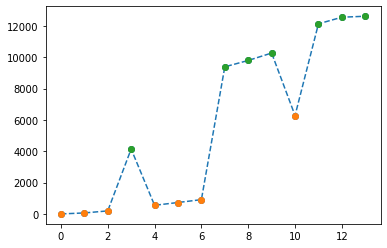

In [582]:
y=hst.snowdistance[0]
plt.plot(y,'o--')
plt.plot([0,1,2,4,5,6,10],y[[0,1,2,4,5,6,10]],'o')
plt.plot([3,7,8,9,11,12,13],y[[3,7,8,9,11,12,13]],'o')

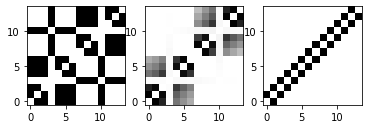

In [585]:
p, (ax1,ax2,ax3) = plt.subplots(1,3) 
ax1.imshow(hst.euclidweight,origin='lower')
ax2.imshow(hst.snowweight,origin='lower')
ax3.imshow(hst.graphweight,origin='lower')
#ax4.imshow(diffusion_distance)
#p.show()
p.savefig('temp.pdf', transparent=True)